# Graph-level Classification

In SARS-CoV-2 studies, the spike protein (antigen), particularly the receptor-binding domain (RBD), is commonly mutated to map epitopes. In this project, we wish to predict the class of antibody epitopes which an antibody sequence is likely to bind to. This will make us able to create epitope specific MSAs when feeding the classifier with multiple sequences. The MSA can enhance the performance when predicting the antigen-antibody complexes using AlphaFold3.

The aim of this notebook is to classify the antibodies when representing the proteins as graphs. These representations are constructed from ESM2 embeddings and attention scores. A GNN is trained to classify the graphs.

### Preparation

We install PyTorch Geometric (PyG).



In [1]:
!pip install torch torch-geometric matplotlib
!pip install fair-esm

The required libraries are loaded.

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import esm
import pickle
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn.conv import GCNConv
from torch.utils.data import random_split
import torch.nn.functional as F
from torch_geometric.nn.pool import global_mean_pool

### Data Preparation

We will import the data.

In [34]:
#work_dir = os.getcwd()
#data_dir = os.path.join(work_dir, '../data')
#data = pd.read_excel(os.path.join(data_dir, 'external/antibody_info.xlsx'), header=1)
data = pd.read_excel('antibody_info.xlsx', header=1)
display(data)

,Antibody Name,Epitope Group,source,D614G,BA.1,BA.2,BA.2.75,BA.5,BQ.1.1,XBB,Heavy chain V gene,Heavy chain J gene,Light chain V gene,Light chain J gene,Heavy chain AA,Light chain AA
0,BD-196,C,WT convalescents,1.93,>10,>10,>10,>10,>10,>10,IGHV1-3,IGHJ6,IGKV2-58,IGKJ1,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYAMHWVRQAPGQRLE...,DVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPG...
1,BD-218,A,WT convalescents,0.0104,0.00849,0.00937,0.0116,5.26,>10,>10,IGHV4-34,IGHJ1,IGKV3-11,IGKJ5,QVQLQQWGAGLLKPSETLSLTCAVYGGSFSDYFWYWIRQPPGKGLE...,EIVLTQSPATLSLSPGERATLSCRASQSVSSYLAWYQQKPGQAPRL...
2,BD-236,A,WT convalescents,0.0173,>10,>10,>10,>10,>10,>10,IGHV3-53,IGHJ6,IGKV1-9,IGKJ4,EVQLVESGGGLIQPGGSLRLSCAASGITVSSNYMSWVRQAPGKGLE...,IQLTQSPSSLSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKLL...
3,BD-254,C,WT convalescents,0.25,>10,>10,>10,>10,>10,>10,IGHV3-23,IGHJ4,IGLV7-46,IGLJ2,EVQLLESGGGLVQPGGSLRLSCAASGFTLSSYAMSWVRQAPGRGLE...,QAVVTQEPSLTVSPGGTVTLTCGSSTGAVTSGHYPYWFQQKPGQAP...
4,BD-255,B,WT convalescents,0.113,>10,>10,>10,>10,>10,>10,IGHV3-30,IGHJ6,IGKV3-15,IGKJ2,QVQLVESGGGVVQPGRSLRLSCVASGFTFSNYDMHWVRQAPGKGLE...,EIVMTQSPAILSVSPGERATLSCRASQSVTRNLAWYQQKPGQAPRL...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,BD55-6726,E2.2,SARS convalescents,>10,>10,>10,>10,>10,>10,>10,IGHV1-58,IGHJ2,IGKV3-24,IGKJ1,QMQLVQSGPEVKRPGTSVKVSCEASGFTFSSSAILWVRQPRGQRLE...,EIVLRQSPATVSLSPGERATLSCRASQSVHNYLAWFQQKPGQAPRL...
3047,BD55-6727,F2,SARS convalescents,0.293,4.37,>10,>10,>10,>10,>10,IGHV3-11,IGHJ1,IGKV1-39,IGKJ2,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMNWIRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQSISNYLNWYQQKPGKAPKL...
3048,BD55-6728,F1,SARS convalescents,>10,>10,>10,>10,>10,>10,>10,IGHV3-64,IGHJ2,IGKV1-39,IGKJ1,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRFAMHWVRQAPGKGLE...,DIQMTQSPSSLSASLGDRVTITCRASQTISRYLNWYQQKPGKAPKV...
3049,BD55-6729,F1,SARS convalescents,>10,>10,>10,>10,>10,>10,>10,IGHV1-18,IGHJ6,IGLV3-25,IGLJ2,QVQLVQSGAEVKKPGTSMRVSCKASGYTFSTYGIIWVRQAPGQGLE...,SYELTQPPSVSVSPGQTARITCSGDAVATQFLYWYQQKSGQAPVMV...


We will only consider the heavy chain. Let us look at the distribution of the lengths of the heavy chain.

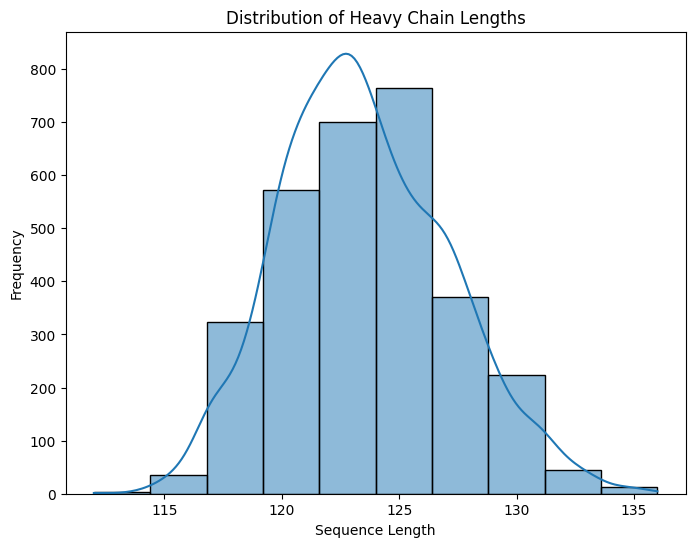

In [35]:
sequences = list(data['Heavy chain AA'])

sequence_lengths = [len(seq) for seq in sequences]

plt.figure(figsize=(8, 6))
sns.histplot(sequence_lengths, kde=True, bins=10)  # kde=True adds a kernel density estimate
plt.title('Distribution of Heavy Chain Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

The class label (Epitope Group) is a character. We convert this into a integer.

In [36]:
# Generate mapping dictionary.
epitope_mapping = {group: code for code, group in enumerate(pd.Categorical(data['Epitope Group']).categories)}

# Map the Epitope Group column using the dictionary
data['Epitope Class'] = data['Epitope Group'].map(epitope_mapping)

display(data)

,Antibody Name,Epitope Group,source,D614G,BA.1,BA.2,BA.2.75,BA.5,BQ.1.1,XBB,Heavy chain V gene,Heavy chain J gene,Light chain V gene,Light chain J gene,Heavy chain AA,Light chain AA,Epitope Class
0,BD-196,C,WT convalescents,1.93,>10,>10,>10,>10,>10,>10,IGHV1-3,IGHJ6,IGKV2-58,IGKJ1,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYAMHWVRQAPGQRLE...,DVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPG...,2
1,BD-218,A,WT convalescents,0.0104,0.00849,0.00937,0.0116,5.26,>10,>10,IGHV4-34,IGHJ1,IGKV3-11,IGKJ5,QVQLQQWGAGLLKPSETLSLTCAVYGGSFSDYFWYWIRQPPGKGLE...,EIVLTQSPATLSLSPGERATLSCRASQSVSSYLAWYQQKPGQAPRL...,0
2,BD-236,A,WT convalescents,0.0173,>10,>10,>10,>10,>10,>10,IGHV3-53,IGHJ6,IGKV1-9,IGKJ4,EVQLVESGGGLIQPGGSLRLSCAASGITVSSNYMSWVRQAPGKGLE...,IQLTQSPSSLSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKLL...,0
3,BD-254,C,WT convalescents,0.25,>10,>10,>10,>10,>10,>10,IGHV3-23,IGHJ4,IGLV7-46,IGLJ2,EVQLLESGGGLVQPGGSLRLSCAASGFTLSSYAMSWVRQAPGRGLE...,QAVVTQEPSLTVSPGGTVTLTCGSSTGAVTSGHYPYWFQQKPGQAP...,2
4,BD-255,B,WT convalescents,0.113,>10,>10,>10,>10,>10,>10,IGHV3-30,IGHJ6,IGKV3-15,IGKJ2,QVQLVESGGGVVQPGRSLRLSCVASGFTFSNYDMHWVRQAPGKGLE...,EIVMTQSPAILSVSPGERATLSCRASQSVTRNLAWYQQKPGQAPRL...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,BD55-6726,E2.2,SARS convalescents,>10,>10,>10,>10,>10,>10,>10,IGHV1-58,IGHJ2,IGKV3-24,IGKJ1,QMQLVQSGPEVKRPGTSVKVSCEASGFTFSSSAILWVRQPRGQRLE...,EIVLRQSPATVSLSPGERATLSCRASQSVHNYLAWFQQKPGQAPRL...,7
3047,BD55-6727,F2,SARS convalescents,0.293,4.37,>10,>10,>10,>10,>10,IGHV3-11,IGHJ1,IGKV1-39,IGKJ2,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMNWIRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQSISNYLNWYQQKPGKAPKL...,10
3048,BD55-6728,F1,SARS convalescents,>10,>10,>10,>10,>10,>10,>10,IGHV3-64,IGHJ2,IGKV1-39,IGKJ1,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRFAMHWVRQAPGKGLE...,DIQMTQSPSSLSASLGDRVTITCRASQTISRYLNWYQQKPGKAPKV...,9
3049,BD55-6729,F1,SARS convalescents,>10,>10,>10,>10,>10,>10,>10,IGHV1-18,IGHJ6,IGLV3-25,IGLJ2,QVQLVQSGAEVKKPGTSMRVSCKASGYTFSTYGIIWVRQAPGQGLE...,SYELTQPPSVSVSPGQTARITCSGDAVATQFLYWYQQKSGQAPVMV...,9


The relation between epitope group and their class label is seen here:

In [37]:
print("Epitope to Group Mapping:", epitope_mapping)

Epitope to Group Mapping: {'A': 0, 'B': 1, 'C': 2, 'D1': 3, 'D2': 4, 'E1': 5, 'E2.1': 6, 'E2.2': 7, 'E3': 8, 'F1': 9, 'F2': 10, 'F3': 11}


We will (for now) only consider a subset.

In [38]:
data_samples = data[['Epitope Group', 'Epitope Class', 'Heavy chain AA']].sample(n = 100)
display(data_samples)

,Epitope Group,Epitope Class,Heavy chain AA
1055,D1,3,QVHLVQSGAEVKKPGASVKVSCKASGYTFSSYAISWVRQAPGQGLE...
2678,E3,8,QVQLQESGPGLVKPSETLSLTCTVSGVSVSSFYWSWLRQPPGKGLE...
2950,E3,8,QVQLVQSGAEVKKPGASVKVSCKASGYTFSNYGISWVRQAPGQGLE...
2933,E3,8,QVQLVQSGAEVKKPGASVKVSCKASGYTFTGHDINWVRQATGQGLE...
1927,E2.2,7,EVQLVESGGGLVQPGGSLRLSCAASGITVSSNYMTWVRQAPGKGLE...
...,...,...,...
2391,F2,10,QVQLVESGGGVVQPGRSLRLSCAASGFIFSSYVMHWVRQPPGKGLE...
621,E3,8,EVQLVQSGAEVKKPGESLKISCKASGYSFISHWIAWVRQKPGKGLE...
178,F2,10,EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLE...
1360,C,2,QVQLVQSGAEVKKPGSSVKVSCKSFGGTLIDYAVSWVRQAPGEGLE...


### ESM2 Representation

We convert the data into a list of the class labels and sequences.

In [39]:
data_subset = [(label, seq) for label, seq in zip(data_samples['Epitope Class'], data_samples['Heavy chain AA'])]
display(data_subset)

[(3,
  'QVHLVQSGAEVKKPGASVKVSCKASGYTFSSYAISWVRQAPGQGLEWMGWITTYNGDTTYSEKLQGRVTMTTDTSTSTAYMDLRSLRSDDTAVYYCARDPGLYCSGVSCYREHDAFDFWGQGTMVTVSS'),
 (8,
  'QVQLQESGPGLVKPSETLSLTCTVSGVSVSSFYWSWLRQPPGKGLEWIGDIDNSGNTNYNPSLRSRVSISIDTSKNQFSLRLSSVTAADTAMYHCARYWHTSGYYWLDPWGQGTLVTVSS'),
 (8,
  'QVQLVQSGAEVKKPGASVKVSCKASGYTFSNYGISWVRQAPGQGLEWMGWISGYSGKTDYAQKFQGRVTLTTDTSPSTAYMELRSLRSDDTAVYYCARDRYSYLYTDYDPFDSWGQGTLVTVSS'),
 (8,
  'QVQLVQSGAEVKKPGASVKVSCKASGYTFTGHDINWVRQATGQGLEWMGWVSPNSGDTGYAHNFQGRVSMTRDTSMNTAYLELNSLRSEDTAVYYCAIYSGSGKFYPDYYYGFDVWGPGTPVTVSS'),
 (7,
  'EVQLVESGGGLVQPGGSLRLSCAASGITVSSNYMTWVRQAPGKGLEWVSVIYAGGSTFYADSVKDRFTISRDNSKNTLYLQMKSLRAEDTAVYYCVRDLVIWGMDVWGPGTTVTVSS'),
 (6,
  'EVQLVESGGGLVQPGRSLRLSCAASGFSFDDYAMHWVRQAPGKGLEWVSGVTWNSGTIGYADSVKGRFIISRDNAKNSLYLQMMSLRAEDTAFYFCAKDGSATKVLWFNPENYYFESWGQGTPVTVSS'),
 (0,
  'EVQMVESGGGLVQPGGSLRLSCAVSGFTVTRNYMSWVRQTPGRGLEWVSIIYPGGSTFYADSVKGRFTISRDNSNNTLFLQMNSLRIEDTAVYYCAREYRGHSWGQGTLVTVSS'),
 (9,
  'QVQLVESGGDVVQPGRSLRLSCAASGFTFSTSVMHWVRQAPGKGLEWVAV

We run the ESM2 model to get the embeddings and contact between residues estimated from the attention scores.

In [ ]:
# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t12_35M_UR50D() #esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Prepare data
batch_labels, batch_strs, batch_tokens = batch_converter(data_subset)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[12], return_contacts=True)
embeddings = results["representations"][12]

# Look at the unsupervised self-attention map contact predictions
#for (_, seq), tokens_len, attention_contacts in zip(data_subset, batch_lens, results["contacts"]):
    #plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    #plt.title(seq)
    #plt.show()

attention_contacts = results["contacts"]

hej test test 2

In [4]:
with open('../data/processed/embed_EMS_8_seperate', 'rb') as f:
    x = pickle.load(f)

UnpicklingError: pickle data was truncated

Let's look at the dimensions of the output.

In [11]:
embeddings.size()

torch.Size([100, 135, 480])

In [12]:
attention_contacts.size()

torch.Size([100, 133, 133])

The model uses padding to make the input of the same length. Thus, we will need to adjust back the embeddings and contact maps.

In [13]:
embeddings_list = []
contacts_list = []

for batch_idx in range(embeddings.shape[0]):
  embeddings_list.append(embeddings[batch_idx, 1 : batch_lens[batch_idx]-1])
  contacts_list.append(attention_contacts[batch_idx, 1 : batch_lens[batch_idx]-1, 1 : batch_lens[batch_idx]-1])

### Create Graphs

We now have the embeddings for each amino acids, which we will use as nodes. Amino acids with contacts above a certain threshold will be considered as neighbors. We create the graphs using PyG. Each protein graph will be generated by providing the folowing features:

- x: Node feature matrix with shape [num_nodes, num_node_features]. This will be the number of amino acids x embedding dimension.

- edge_index: Graph connectivity with shape [2, num_edges]. This will be neighboring amino acids within the protein.

- edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]. This will be the score betweeen amino acids from the contact map.

data.y: This will be the target. In our case, we wish to predict the epitope class.

In [16]:
epitope_mapping.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

In [17]:
pygraphs = []
threshold = 0.0005
epitope_classes = torch.tensor(data_samples['Epitope Class'].values, dtype=torch.long)
epitope_classes = epitope_classes.unsqueeze(0)

for batch_idx in range(len(embeddings_list)):

  contacts = contacts_list[batch_idx]

  edge_indices = (contacts > threshold).nonzero(as_tuple=False).T
  edge_scores = contacts[edge_indices[0], edge_indices[1]]

  # Create Data object
  graph = Data(x = embeddings_list[batch_idx],
               edge_index = edge_indices,
               edge_attr = edge_scores.unsqueeze(1),
               y = epitope_classes[:, batch_idx])

  pygraphs.append(graph)

In [18]:
pygraphs

[Data(x=[125, 480], edge_index=[2, 15105], edge_attr=[15105, 1], y=[1]),
 Data(x=[116, 480], edge_index=[2, 12940], edge_attr=[12940, 1], y=[1]),
 Data(x=[129, 480], edge_index=[2, 16132], edge_attr=[16132, 1], y=[1]),
 Data(x=[129, 480], edge_index=[2, 16131], edge_attr=[16131, 1], y=[1]),
 Data(x=[122, 480], edge_index=[2, 14360], edge_attr=[14360, 1], y=[1]),
 Data(x=[116, 480], edge_index=[2, 12952], edge_attr=[12952, 1], y=[1]),
 Data(x=[130, 480], edge_index=[2, 16398], edge_attr=[16398, 1], y=[1]),
 Data(x=[122, 480], edge_index=[2, 14376], edge_attr=[14376, 1], y=[1]),
 Data(x=[120, 480], edge_index=[2, 13893], edge_attr=[13893, 1], y=[1]),
 Data(x=[127, 480], edge_index=[2, 15625], edge_attr=[15625, 1], y=[1]),
 Data(x=[124, 480], edge_index=[2, 14859], edge_attr=[14859, 1], y=[1]),
 Data(x=[121, 480], edge_index=[2, 14125], edge_attr=[14125, 1], y=[1]),
 Data(x=[129, 480], edge_index=[2, 16142], edge_attr=[16142, 1], y=[1]),
 Data(x=[133, 480], edge_index=[2, 16903], edge_att

In [19]:
edge_scores

tensor([9.9903e-01, 5.4206e-04, 3.2459e-02,  ..., 8.4780e-03, 8.4780e-03,
        8.4780e-03])

### Classification Model

In [20]:
# Split dataset into training and test sets
train_size = int(0.7 * len(pygraphs))
test_size = len(pygraphs) - train_size
train_dataset, test_dataset = random_split(pygraphs, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [21]:
print(train_size)
print(test_size)

70
30


In [26]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim) # maps the learned graph-level feature representations to the output space, enabling prediction tasks.

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch) # Essential for aggregating node-level features into a single graph-level feature vector.
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Initialize model, loss, and optimizer
num_class = torch.max(epitope_classes).item() + 1
model = GNN(input_dim=480, hidden_dim=100, output_dim = num_class)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [27]:
for epoch in range(100):
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 89.5971
Epoch 2, Loss: 83.7023
Epoch 3, Loss: 83.6076
Epoch 4, Loss: 82.9375
Epoch 5, Loss: 82.2021
Epoch 6, Loss: 82.2111
Epoch 7, Loss: 82.0930
Epoch 8, Loss: 81.9990
Epoch 9, Loss: 82.3395
Epoch 10, Loss: 82.0440
Epoch 11, Loss: 82.0659
Epoch 12, Loss: 81.6555
Epoch 13, Loss: 81.7951
Epoch 14, Loss: 81.7348
Epoch 15, Loss: 82.1617
Epoch 16, Loss: 82.2427
Epoch 17, Loss: 82.5836
Epoch 18, Loss: 81.6633
Epoch 19, Loss: 81.5125
Epoch 20, Loss: 81.5021
Epoch 21, Loss: 82.3430
Epoch 22, Loss: 81.7077
Epoch 23, Loss: 81.9053
Epoch 24, Loss: 81.5513
Epoch 25, Loss: 81.2305
Epoch 26, Loss: 81.5530
Epoch 27, Loss: 81.4080
Epoch 28, Loss: 81.5237
Epoch 29, Loss: 81.2335
Epoch 30, Loss: 81.2201
Epoch 31, Loss: 81.3862
Epoch 32, Loss: 81.5938
Epoch 33, Loss: 81.4222
Epoch 34, Loss: 81.2927
Epoch 35, Loss: 81.4911
Epoch 36, Loss: 81.1612
Epoch 37, Loss: 81.5097
Epoch 38, Loss: 81.1602
Epoch 39, Loss: 81.2947
Epoch 40, Loss: 81.3561
Epoch 41, Loss: 81.4113
Epoch 42, Loss: 81.4658
E

In [28]:
model.eval()
correct = 0
for data in test_loader:
    out = model(data.x, data.edge_index, data.batch)
    pred = out.argmax(dim=1)
    correct += (pred == data.y).sum().item()

accuracy = correct / len(test_dataset)
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.17
